# SIR Compartmental Model

In [1]:
# Import libraries.
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy import integrate, optimize

# Pretty colors.
c = [(0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
     (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
     (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]

## The Model

In the SIR model, there are three "compartments": susceptible, infected, and recovered. For a population of $N$ individuals, we let $S$, $I$, and $R$ represent the counts of each compartment and $s = \frac{S}{N}$, $i = \frac{I}{N}$, and $r = \frac{R}{N}$ represent the proportions of each compartment. 

For effective contact rate $\beta$ and removal rate $\nu$, we have the following ordinary differential equations describing $s$, $i$, and $r$.
\begin{align*}
    \frac{\text{d}s}{\text{d}t} &= -\beta s i\\
    \frac{\text{d}i}{\text{d}t} &= \beta s i - \nu i\\
    \frac{\text{d}r}{\text{d}t} &= \nu i
\end{align*}
These can readily be written as ordinary differential equations describing $S$, $I$, and $R$.
\begin{align*}
    \frac{\text{d}S}{\text{d}t} &= -\frac{\beta}{N} S I\\
    \frac{\text{d}I}{\text{d}t} &= \frac{\beta}{N} S I - \nu I\\
    \frac{\text{d}R}{\text{d}t} &= \nu I
\end{align*}

## Fitting


I'm using the [```flu```](https://rdrr.io/cran/epimdr/man/flu.html) dataset from ```epimdr```.

In [2]:
# Acquire data.
# This data is taken from flu dataset in the R library
# epimdr. It is the same data as in the BMJ.

t_obs = np.arange(0, 15)
I_obs = [1, 3, 8, 26, 76, 225, 298, 258, 233, 189, 128, 68, 29, 14, 4]

In [3]:
# Fit the parameters.

N = 763

# Defines the system of differential equations
# for the SIR model.
def sir(sir, t, beta, nu):
    S, I, R = sir
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - nu * I
    dRdt = nu * I
    return dSdt, dIdt, dRdt

S_0 = 762
I_0 = 1
R_0 = 0

# Returns the infected data for the SIR model with 
# inputted parameters beta and nu.
def fit_odeint(t, beta, nu):
    return integrate.odeint(sir, (S_0, I_0, R_0), t_obs, args = (beta, nu))[:,1]

# Solves for the least squares beta and nu.
opt, cov = optimize.curve_fit(fit_odeint, t_obs, I_obs)
beta, nu = opt

# Variance in beta and nu.
cov[0][0], cov[1][1]

(0.0006101580917561955, 0.00022376543324478186)

## Modeling

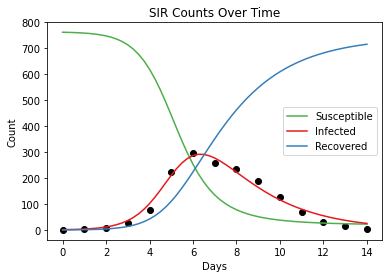

In [4]:
# Run model.

# Compute S, I, and R with fitted parameters.
t = np.linspace(0, 14, 57)
fit = integrate.odeint(sir, (S_0, I_0, R_0), t, args = (beta, nu))
S, I, R = np.hsplit(fit, 3)

# Plot observed data and fitted S, I, and R
# counts.
plt.plot(t_obs, I_obs, 'o', c = 'k')
plt.plot(t, S, label = 'Susceptible', c= c[0])
plt.plot(t, I, label = 'Infected', c = c[1])
plt.plot(t, R, label = 'Recovered', c = c[2])

plt.xlabel('Days')
plt.ylabel('Count')
plt.title('SIR Counts Over Time')

plt.legend();

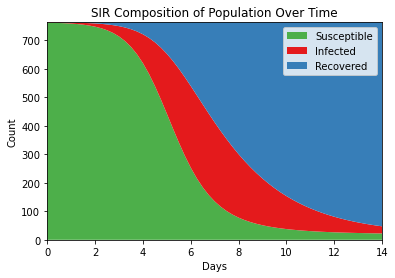

In [5]:
# Pretty composition plot.

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(t, fit.T, labels = ['Susceptible', 'Infected', 'Recovered'], colors = c)
ax.set_title('SIR Composition of Population Over Time')
ax.set_xlabel('Days')
ax.set_ylabel('Count')
ax.margins(0, 0)

plt.legend();

## Analysis

We compute the base reproduction number $R_0 = \frac{\beta}{\nu}$ to obtain $R_0 \approx 3.76$. 

In [6]:
R0 = beta / nu
R0

3.7641794078466897

Under ideal conditions, the assumptions of our SIR model hold, so we can reliably suppose that $R_0 = 3.76$, which means that each case infects around four other cases. To interrupt the transmission of the disease, the vaccine must reduce this to each case infecting fewer than one other case. If $p_{\text{imm}}$ is the proportion of the population immune to the virus, then we want that $R_0(1 - p_{\text{imm}}) < 1$, or $p_{\text{imm}} > 1 - \frac{1}{R_0}$.

Supposing a vaccine efficacy $\varepsilon$ for $p_{\text{vac}}$ the proportion of the population vaccinated, we have that $p_{\text{vac}} \varepsilon > 1 - \frac{1}{R_0}$, or 
$$p_{\text{vac}} > \frac{1 - \frac{1}{R_0}}{\varepsilon},$$
as stated in [this paper](https://academic.oup.com/cid/article/52/7/911/299077).

In [7]:
pvac = (1 - 1/R0) / 0.9
pvac, pvac * N

(0.815930942813361, 622.5553093665944)

We would need to vaccinate at least $82\%$ of the population, or $623$ students, to interrupt transmission. If each vaccine is $\$1$, the minimum amount of money needed to disrupt transmission is $\$623$.